In [1]:
import numpy as np
from gammapy.stats import WStatCountsStatistic

import astropy.units as u
import matplotlib.pyplot as plt

from numpy import load
import zipfile

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 20
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = 'dashed' 

In [2]:
def draw_errorbars(ax, h, color):
    y = h[0]
    binEdges = h[1]
    
    bin_centers = 0.5*(binEdges[1:]+binEdges[:-1])
    menStd     = np.sqrt(y)
    width      = 0.05

    ax.errorbar(
    bin_centers,
    y,
    yerr = y**0.5,
    xerr=0,
    marker = '.',
    ls = '',
    color = color
)
    
    return ax, bin_centers

## Time

In [3]:
obs_time = 123130.63 * u.s # seconds

## Significance calculation

In [5]:
# ON region P1: 
phases_on_p1 = [0.983, 0.026]
p1_duty_cycle = (1 - phases_on_p1[0]) + phases_on_p1[1]

# ON region P2:
phases_on_p2 = [0.377, 0.422]
p2_duty_cycle = phases_on_p2[1] - phases_on_p2[0]

# OFF region:
phase_off = [0.520, 0.870]
off_duty_cycle = phase_off[1] - phase_off[0]

# Number of ON/OFF
Non_p1 = 323537
Non_p2 = 339090
Noff = 2595965
Nevents = 7437473

######## P1 ######### 
alpha_p1 = p1_duty_cycle / off_duty_cycle
Nex_p1 = Non_p1 - alpha_p1 * Noff
Significance_p1 = Nex_p1 / np.sqrt(alpha_p1 * Noff)

stat_p1 = WStatCountsStatistic(n_on=Non_p1, n_off=Noff, alpha=alpha_p1)
significance_p1_lima = stat_p1.sqrt_ts

######## P2 ######### 
alpha_p2 = p2_duty_cycle / off_duty_cycle
Nex_p2 = Non_p2 - alpha_p2 * Noff
Significance_p2 = Nex_p2 / np.sqrt(alpha_p2 * Noff)

stat_p2 = WStatCountsStatistic(n_on=Non_p2, n_off=Noff, alpha=alpha_p2)
significance_p2_lima = stat_p2.sqrt_ts

######## Joint ######### 
stat_joint = WStatCountsStatistic(n_on=Non_p1 + Non_p2 , n_off=Noff , alpha=alpha_p1 + alpha_p2)
significance_joint_lima = stat_joint.sqrt_ts


#########################################################################################
textstr = r'Events = {:.0f} '\
            f'\n'\
            r'Time = {:.1f}'\
            f'\n'\
            r'N$_{{\rm ex}}$ (P1) = {:.0f} '\
            f'\n'\
            r'Significance (P1) = {:.1f} $\sigma$ '\
            f'\n'\
            r'N$_{{\rm ex}}$ (P2) = {:.0f} '\
            f'\n'\
            r'Significance (P2) = {:.1f} $\sigma$'\
            f'\n'\
            r'$\bf{{Significance\ (Joint)}}$ $\bf{{= {:.1f} \sigma}}$'.format(Nevents,
                                                      obs_time.to(u.h),
                                                      Nex_p1,
                                                      significance_p1_lima,
                                                      Nex_p2,
                                                      significance_p2_lima,
                                                      significance_joint_lima)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
########################################################################################

print(textstr)
print(f'Non_p1 {Non_p1}')
print(f'Non_p2 {Non_p2}')
print(f'Noff {Noff}')
print(f'Noff * alpha_p1 {Noff * alpha_p1}')
print(f'Noff * alpha_p2 {Noff * alpha_p2}')

print(f'alpha_p1 {alpha_p1}')
print(f'alpha_p2 {alpha_p2}')

Events = 7437473 
Time = 34.2 h
N$_{\rm ex}$ (P1) = 4604 
Significance (P1) = 7.7 $\sigma$ 
N$_{\rm ex}$ (P2) = 5323 
Significance (P2) = 8.6 $\sigma$
$\bf{Significance\ (Joint)}$ $\bf{= 11.0 \sigma}$
Non_p1 323537
Non_p2 339090
Noff 2595965
Noff * alpha_p1 318932.84285714297
Noff * alpha_p2 333766.92857142846
alpha_p1 0.1228571428571429
alpha_p2 0.12857142857142853


In [6]:
def format_axes(ax):
    # OFF regions
    ax.axvspan(0, phases_on_p1[1], ymin=0., ymax=1., alpha=0.4, color='salmon', hatch='/')
    ax.axvspan(phases_on_p1[0], 1 + phases_on_p1[1], ymin=0., ymax=1., alpha=0.4, color='salmon', hatch='/')
    ax.axvspan(phases_on_p2[0], phases_on_p2[1], ymin=0., ymax=1., alpha=0.4, color='salmon', hatch='/')
    ax.axvspan(phases_on_p1[0] + 1, 1.00 + 1, ymin=0., ymax=1., alpha=0.4, color='salmon', hatch='/')
    ax.axvspan(phases_on_p2[0] + 1, phases_on_p2[1] + 1, ymin=0., ymax=1., alpha=0.4, color='salmon', hatch='/')

    # ON regions
    ax.axvspan(phase_off[0], phase_off[1], ymin=0., ymax=1., alpha=0.2, color='gray', hatch='\\')
    ax.axvspan(phase_off[0] + 1, phase_off[1] + 1, ymin=0., ymax=1., alpha=0.2, color='gray', hatch='\\')

    ax.set_xlim(0, 2)
    ax.set_xlabel(f'Pulsar phase [$\phi$]')
    ax.set_ylabel(f'Events')

In [7]:
def fill_excesses(ax, hphase, bin_centers, off_average):
    
    ## Fill Nexcesses
    #P1
    bin_width = hphase[1][1] - hphase[1][0]
    ax.bar(bin_centers[((bin_centers < phases_on_p1[1]) | (bin_centers > phases_on_p1[0])) & (bin_centers < 1)], 
       hphase[0][((bin_centers < phases_on_p1[1]) | (bin_centers > phases_on_p1[0])) & (bin_centers < 1)] - off_average, 
       bottom = off_average, width = bin_width, color = '#ff022d')
    ax.bar(bin_centers[((bin_centers < phases_on_p1[1] + 1) | (bin_centers > phases_on_p1[0]  + 1)) & (bin_centers > 1)], 
       hphase[0][((bin_centers < phases_on_p1[1]  + 1) | (bin_centers > phases_on_p1[0]  + 1)) & (bin_centers > 1)] - off_average, 
       bottom = off_average, width = bin_width, color = '#ff022d')
    #P2
    ax.bar(bin_centers[(bin_centers < phases_on_p2[1] ) & (bin_centers > phases_on_p2[0] )], 
       hphase[0][(bin_centers < phases_on_p2[1]) & (bin_centers > phases_on_p2[0])] - off_average, 
       bottom = off_average, width = bin_width, color = '#ff022d')
    ax.bar(bin_centers[(bin_centers < phases_on_p2[1] + 1) & (bin_centers > phases_on_p2[0]  + 1)], 
       hphase[0][(bin_centers < phases_on_p2[1]  + 1) & (bin_centers > phases_on_p2[0]  + 1)] - off_average, 
       bottom = off_average, width = bin_width, color = '#ff022d')

    return ax

In [8]:
hphase = (np.array([125762., 124561., 123834., 124373., 124054., 124010., 123870.,
        123670., 123996., 123513., 124392., 124565., 124581., 123949.,
        123378., 123685., 124065., 124171., 123428., 124119., 124445.,
        124198., 125242., 125931., 125796., 123670., 124039., 123612.,
        123644., 123707., 123781., 123474., 123936., 123386., 123503.,
        124196., 123619., 123426., 124349., 123889., 123660., 123836.,
        123436., 123504., 123638., 123749., 123339., 122917., 123909.,
        123221., 123396., 123447., 123805., 122948., 123657., 123789.,
        123965., 123845., 124069., 125524., 125762., 124561., 123834.,
        124373., 124054., 124010., 123870., 123670., 123996., 123513.,
        124392., 124565., 124581., 123949., 123378., 123685., 124065.,
        124171., 123428., 124119., 124445., 124198., 125242., 125931.,
        125796., 123670., 124039., 123612., 123644., 123707., 123781.,
        123474., 123936., 123386., 123503., 124196., 123619., 123426.,
        124349., 123889., 123660., 123836., 123436., 123504., 123638.,
        123749., 123339., 122917., 123909., 123221., 123396., 123447.,
        123805., 122948., 123657., 123789., 123965., 123845., 124069.,
        125524.]),
 np.array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.18333333, 0.2       , 0.21666667, 0.23333333,
        0.25      , 0.26666667, 0.28333333, 0.3       , 0.31666667,
        0.33333333, 0.35      , 0.36666667, 0.38333333, 0.4       ,
        0.41666667, 0.43333333, 0.45      , 0.46666667, 0.48333333,
        0.5       , 0.51666667, 0.53333333, 0.55      , 0.56666667,
        0.58333333, 0.6       , 0.61666667, 0.63333333, 0.65      ,
        0.66666667, 0.68333333, 0.7       , 0.71666667, 0.73333333,
        0.75      , 0.76666667, 0.78333333, 0.8       , 0.81666667,
        0.83333333, 0.85      , 0.86666667, 0.88333333, 0.9       ,
        0.91666667, 0.93333333, 0.95      , 0.96666667, 0.98333333,
        1.        , 1.01666667, 1.03333333, 1.05      , 1.06666667,
        1.08333333, 1.1       , 1.11666667, 1.13333333, 1.15      ,
        1.16666667, 1.18333333, 1.2       , 1.21666667, 1.23333333,
        1.25      , 1.26666667, 1.28333333, 1.3       , 1.31666667,
        1.33333333, 1.35      , 1.36666667, 1.38333333, 1.4       ,
        1.41666667, 1.43333333, 1.45      , 1.46666667, 1.48333333,
        1.5       , 1.51666667, 1.53333333, 1.55      , 1.56666667,
        1.58333333, 1.6       , 1.61666667, 1.63333333, 1.65      ,
        1.66666667, 1.68333333, 1.7       , 1.71666667, 1.73333333,
        1.75      , 1.76666667, 1.78333333, 1.8       , 1.81666667,
        1.83333333, 1.85      , 1.86666667, 1.88333333, 1.9       ,
        1.91666667, 1.93333333, 1.95      , 1.96666667, 1.98333333,
        2.        ]))

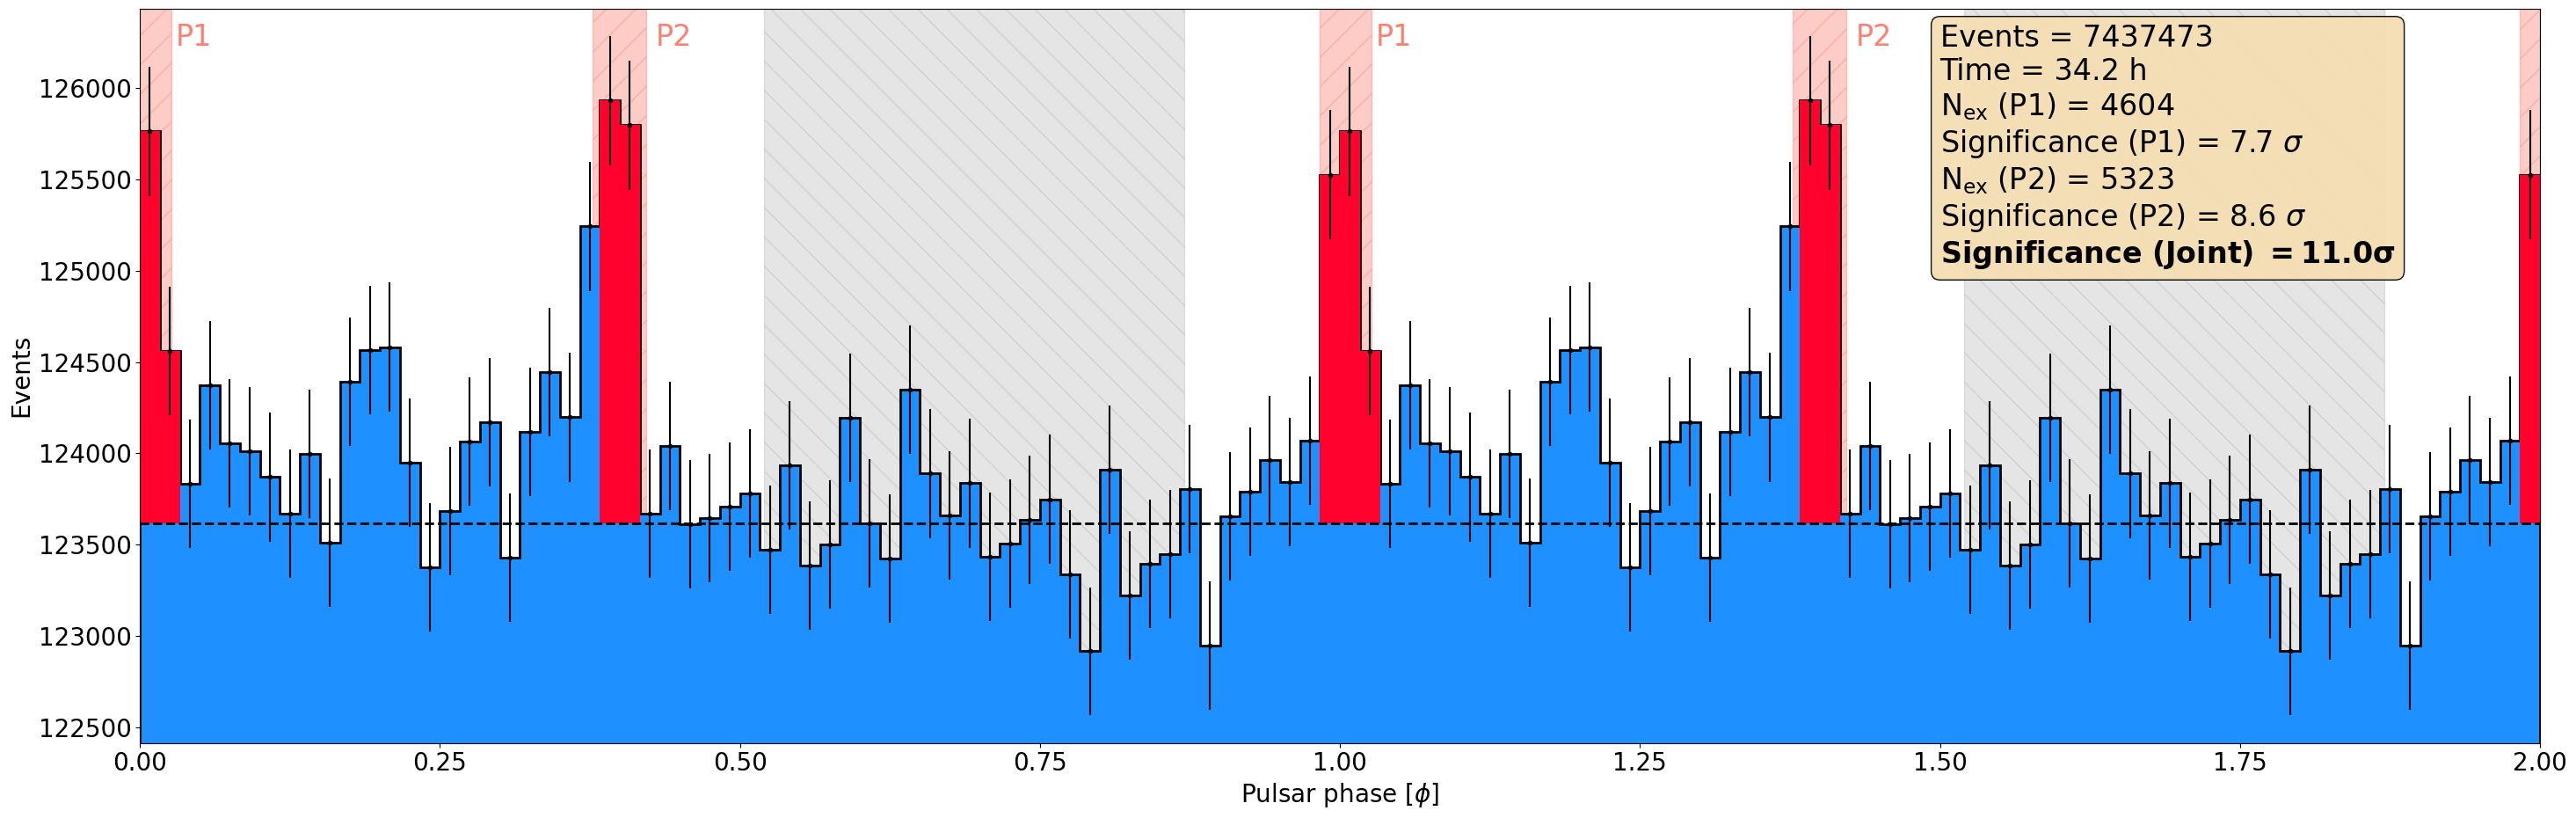

In [9]:
nbins = 60
fig, ax = plt.subplots(figsize = (30,10))
plt.rcParams['font.size'] = 30


format_axes(ax)

#hphase = ax.hist(phases_vs_energy_flat_for_plotting, 
#                 bins = nbins * 2, range=(0,2), color='dodgerblue')
#hphase = ax.hist(phases_vs_energy_flat_for_plotting, histtype='step', lw=2,
#                 bins = nbins * 2, color = 'k', range=(0,2))


ax.stairs(hphase[0], hphase[1], color='dodgerblue', fill=True)
ax.stairs(hphase[0], hphase[1], color='k', lw=2)

ax, bin_centers = draw_errorbars(ax, hphase, 'k')


# OFF average
histogram_bin_size = hphase[1][1] - hphase[1][0]
off_normalization = histogram_bin_size / off_duty_cycle
off_average = off_normalization * Noff
ax.hlines(y=off_average, xmin=0, xmax=2, ls='--', color = 'k', lw=2)

fill_excesses(ax, hphase, bin_centers, off_average)

# Limits
max_min_diff = (np.max(hphase[0]) - np.min(hphase[0]))
ax.set_ylim(np.min(hphase[0]) - max_min_diff * 1/6, np.max(hphase[0]) +  max_min_diff * 1/6)
ax.text(0.015, 0.95, 'P1', fontsize=24, color='salmon', transform=ax.transAxes)
ax.text(0.515, 0.95, 'P1', fontsize=24, color='salmon', transform=ax.transAxes)
ax.text(0.215, 0.95, 'P2', fontsize=24, color='salmon', transform=ax.transAxes)
ax.text(0.715, 0.95, 'P2', fontsize=24, color='salmon', transform=ax.transAxes)

ax.text(0.75, 0.98, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top', bbox=props)
plt.tight_layout()

!mkdir -p figures
fig.savefig('figures/Phaseogram_filled_no_title_landscape.png')
fig.savefig('figures/Phaseogram_filled_no_title_landscape.pdf')